<a href="https://colab.research.google.com/github/sungjindo/JPX/blob/Doh/kaggle_JPX_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#module

In [1]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

path = '/content/gdrive/MyDrive/JPX/dataset/JPX'

from google.colab import drive
drive.mount('/content/gdrive')



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mounted at /content/gdrive


In [2]:
train = pd.read_csv(path+'/train_files/stock_prices.csv')


#0.What to predict ? : Take a look at an example of sample submission

In [3]:
sample = pd.read_csv("/content/gdrive/MyDrive/JPX/dataset/JPX/example_test_files/sample_submission.csv")
sample

,Date,SecuritiesCode,Rank
0,2021-12-06,1301,0
1,2021-12-06,1332,1
2,2021-12-06,1333,2
3,2021-12-06,1375,3
4,2021-12-06,1376,4
...,...,...,...
111995,2022-02-28,9990,1995
111996,2022-02-28,9991,1996
111997,2022-02-28,9993,1997
111998,2022-02-28,9994,1998


In [4]:
sample.nunique()

Date                56
SecuritiesCode    2000
Rank              2000
dtype: int64

Predict Ranks by **date** and **Securities Code **(stocks).

Rank indicates the ranking of the change rate of **the closing price** (Close) of **the next day** and **the next day** for each of 2000 stocks, counting from the largest of 2000 stocks. (If the rate of change is large, it will be to plus direction, so if you buy it for 100 dollar, it will be 120 dollar. If the rate of change is small, it will be large to minus direction, so if you sell it for 100 dollar, it will be 80 dollar. This makes the benefit.)

It's a little difficult to understand, isn't it? Let's take a simple example.

**날짜** 및 **증권 코드 **(주식)별로 순위를 예측합니다.

Rank는 2000종목별 **익일**, **익일**의 **종가**(종가)의 변화율을 2000종목 중 최대 2000종목부터 랭킹한 것입니다. (변동율이 크면 플러스 방향이 되므로 100달러에 사면 120달러가 됩니다. 변화율이 작으면 마이너스 방향으로 커지기 때문에 100달러에 팔면 80달러가 됩니다.

조금 이해하기 어렵죠? 간단한 예를 들어보겠습니다.

#1.Understand how to calculate scores and deepen your understanding of Rank

In [ ]:
stock_prices = pd.read_csv('/content/gdrive/MyDrive/JPX/dataset/JPX/train_files/stock_prices.csv')
stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


In [ ]:
stock_prices["Date"] = pd.to_datetime(stock_prices["Date"]) 

## 1.1 Let's look at only one stock

In [ ]:
tmpdf = stock_prices[stock_prices["SecuritiesCode"]==1301].reset_index(drop=True)
tmpdf.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092


Step 1 : Try to calculate TARGET (change rate of Close on the next day and the next day) by yourself.

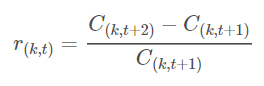

In [ ]:
# close is the stock price at the end of the day.

tmpdf["Close_shift1"] = tmpdf["Close"].shift(-1)
tmpdf["Close_shift2"] = tmpdf["Close"].shift(-2)

tmpdf["rate"] = (tmpdf["Close_shift2"] - tmpdf["Close_shift1"]) / tmpdf["Close_shift1"]
tmpdf

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Close_shift1,Close_shift2,rate
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,2738.0,2740.0,0.000730
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,2740.0,2748.0,0.002920
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,2748.0,2745.0,-0.001092
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,2745.0,2731.0,-0.005100
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,2731.0,2722.0,-0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,20211129_1301,2021-11-29,1301,2975.0,2984.0,2951.0,2951.0,14300,1.0,NaN,False,0.003793,2900.0,2911.0,0.003793
1198,20211130_1301,2021-11-30,1301,2953.0,2997.0,2900.0,2900.0,20500,1.0,NaN,False,0.007558,2911.0,2933.0,0.007558
1199,20211201_1301,2021-12-01,1301,2909.0,2936.0,2909.0,2911.0,10600,1.0,NaN,False,0.016706,2933.0,2982.0,0.016706
1200,20211202_1301,2021-12-02,1301,2949.0,2973.0,2933.0,2933.0,15200,1.0,NaN,False,-0.003689,2982.0,NaN,NaN


'Securitiescode' is stocks like items. In this case, i pick 'Code1301' and then make PER(Price earning ratio) based on t+1 day.

**Rank calculation.**

First, let's take a look at only one day. * Please note that not all 2000 stocks have data depending on the date.

In [ ]:
stock_prices.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154


In [ ]:
tmpdf2 = stock_prices[stock_prices["Date"]=="2021-12-02"].reset_index(drop=True)  #look at the data based on Date : '2021-12-02'
tmpdf2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211202_1301,2021-12-02,1301,2949.0,2973.0,2933.0,2933.0,15200,1.0,NaN,False,-0.003689
1,20211202_1332,2021-12-02,1332,566.0,577.0,565.0,573.0,1525800,1.0,NaN,False,0.006838
2,20211202_1333,2021-12-02,1333,2276.0,2314.0,2267.0,2303.0,157000,1.0,NaN,False,0.008058
3,20211202_1375,2021-12-02,1375,1220.0,1244.0,1209.0,1212.0,121600,1.0,NaN,False,-0.008907
4,20211202_1376,2021-12-02,1376,1353.0,1373.0,1327.0,1327.0,7800,1.0,NaN,False,0.014264
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20211202_9990,2021-12-02,9990,518.0,519.0,507.0,507.0,109500,1.0,NaN,False,-0.020833
1996,20211202_9991,2021-12-02,9991,777.0,791.0,775.0,778.0,46600,1.0,NaN,False,-0.011335
1997,20211202_9993,2021-12-02,9993,1672.0,1685.0,1650.0,1650.0,6900,1.0,NaN,False,-0.010942
1998,20211202_9994,2021-12-02,9994,2340.0,2382.0,2340.0,2362.0,9200,1.0,NaN,False,0.012139


Rank in descending order of Target. I do sort it for understanding.

 **Rank is tied to 0-1999, so don't forget -1 (if you don't enter it, you will get an error)**

In [ ]:
tmpdf2["rank"] = tmpdf2["Target"].rank(ascending=False,method="first") -1
tmpdf2 = tmpdf2.sort_values("rank").reset_index(drop=True)

In [ ]:
tmpdf2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211202_4699,2021-12-02,4699,2037.0,2149.0,2037.0,2143.0,31000,1.0,NaN,False,0.231481,0.0
1,20211202_4488,2021-12-02,4488,5900.0,5990.0,5690.0,5700.0,57100,1.0,NaN,False,0.149254,1.0
2,20211202_8057,2021-12-02,8057,4710.0,4820.0,4615.0,4640.0,29800,1.0,NaN,False,0.123110,2.0
3,20211202_9632,2021-12-02,9632,8110.0,8150.0,8000.0,8030.0,3900,1.0,NaN,False,0.107011,3.0
4,20211202_6958,2021-12-02,6958,510.0,525.0,502.0,517.0,639200,1.0,NaN,False,0.103113,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20211202_4483,2021-12-02,4483,8200.0,8590.0,8180.0,8410.0,320300,1.0,NaN,False,-0.085480,1995.0
1996,20211202_6879,2021-12-02,6879,731.0,745.0,702.0,707.0,735500,1.0,NaN,False,-0.087248,1996.0
1997,20211202_4168,2021-12-02,4168,4280.0,4390.0,4200.0,4335.0,72600,1.0,NaN,False,-0.094595,1997.0
1998,20211202_3994,2021-12-02,3994,7490.0,7500.0,7060.0,7070.0,735000,1.0,NaN,False,-0.094980,1998.0


In terms of meaning, the smaller the rank, the larger the rate of change to +, so it is profitable to buy it. The larger the rank value, the greater the rate of change, so it is profitable to sell it.

의미적으로는 랭크가 작을수록 +로의 변화율이 커지므로 매수하는 것이 유리하다. 랭크 값이 클수록 변화율이 커지므로 매도하는 것이 유리합니다.

# Step 3 Calculation of daily spread return of this day

If you look at, for the **top 200** and **bottom 200** of the rank, multiply the rate of change target of the closing price you just understood by weight (1 ~ 2). I'm not good at formulas, so I'll calculate it.

보시면 순위의 **상위 200개**와 **하위 200개**에 대해 방금 파악한 종가의 목표 변화율에 가중치(1~2)를 곱한 것입니다. 제가 공식을 잘 못해서 계산해보겠습니다.

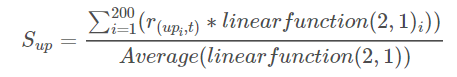

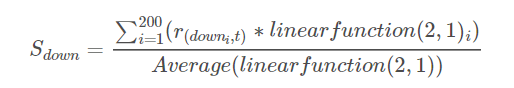

Consider only a rank of 200 from the top.(200 larger Targets)

In [ ]:
tmpdf2_top200 = tmpdf2.iloc[:200,:]
tmpdf2_top200

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211202_4699,2021-12-02,4699,2037.0,2149.0,2037.0,2143.0,31000,1.0,NaN,False,0.231481,0.0
1,20211202_4488,2021-12-02,4488,5900.0,5990.0,5690.0,5700.0,57100,1.0,NaN,False,0.149254,1.0
2,20211202_8057,2021-12-02,8057,4710.0,4820.0,4615.0,4640.0,29800,1.0,NaN,False,0.123110,2.0
3,20211202_9632,2021-12-02,9632,8110.0,8150.0,8000.0,8030.0,3900,1.0,NaN,False,0.107011,3.0
4,20211202_6958,2021-12-02,6958,510.0,525.0,502.0,517.0,639200,1.0,NaN,False,0.103113,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20211202_6272,2021-12-02,6272,1291.0,1343.0,1291.0,1308.0,23900,1.0,NaN,False,0.012734,195.0
196,20211202_6324,2021-12-02,6324,4500.0,4635.0,4400.0,4490.0,417100,1.0,NaN,False,0.012698,196.0
197,20211202_2899,2021-12-02,2899,1899.0,1919.0,1880.0,1906.0,39400,1.0,NaN,False,0.012697,197.0
198,20211202_2185,2021-12-02,2185,1376.0,1376.0,1355.0,1355.0,200,1.0,NaN,False,0.012687,198.0


Calculate the top 200 weights and embed them in finweights

In [ ]:
weights = np.linspace(start=2, stop=1, num =200)
weights

array([2.        , 1.99497487, 1.98994975, 1.98492462, 1.9798995 ,
       1.97487437, 1.96984925, 1.96482412, 1.95979899, 1.95477387,
       1.94974874, 1.94472362, 1.93969849, 1.93467337, 1.92964824,
       1.92462312, 1.91959799, 1.91457286, 1.90954774, 1.90452261,
       1.89949749, 1.89447236, 1.88944724, 1.88442211, 1.87939698,
       1.87437186, 1.86934673, 1.86432161, 1.85929648, 1.85427136,
       1.84924623, 1.84422111, 1.83919598, 1.83417085, 1.82914573,
       1.8241206 , 1.81909548, 1.81407035, 1.80904523, 1.8040201 ,
       1.79899497, 1.79396985, 1.78894472, 1.7839196 , 1.77889447,
       1.77386935, 1.76884422, 1.7638191 , 1.75879397, 1.75376884,
       1.74874372, 1.74371859, 1.73869347, 1.73366834, 1.72864322,
       1.72361809, 1.71859296, 1.71356784, 1.70854271, 1.70351759,
       1.69849246, 1.69346734, 1.68844221, 1.68341709, 1.67839196,
       1.67336683, 1.66834171, 1.66331658, 1.65829146, 1.65326633,
       1.64824121, 1.64321608, 1.63819095, 1.63316583, 1.62814

In [ ]:
tmpdf2_top200['weights'] = weights
tmpdf2_top200.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights
0,20211202_4699,2021-12-02,4699,2037.0,2149.0,2037.0,2143.0,31000,1.0,NaN,False,0.231481,0.0,2.000000
1,20211202_4488,2021-12-02,4488,5900.0,5990.0,5690.0,5700.0,57100,1.0,NaN,False,0.149254,1.0,1.994975
2,20211202_8057,2021-12-02,8057,4710.0,4820.0,4615.0,4640.0,29800,1.0,NaN,False,0.123110,2.0,1.989950


In [ ]:
# Multiply this by target
tmpdf2_top200["calc_weights"]=tmpdf2_top200["Target"] *tmpdf2_top200['weights']
tmpdf2_top200.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights,calc_weights
0,20211202_4699,2021-12-02,4699,2037.0,2149.0,2037.0,2143.0,31000,1.0,NaN,False,0.231481,0.0,2.000000,0.462963
1,20211202_4488,2021-12-02,4488,5900.0,5990.0,5690.0,5700.0,57100,1.0,NaN,False,0.149254,1.0,1.994975,0.297757
2,20211202_8057,2021-12-02,8057,4710.0,4820.0,4615.0,4640.0,29800,1.0,NaN,False,0.123110,2.0,1.989950,0.244983


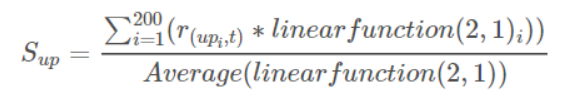

In [ ]:
#The sum of this is divided by weight, Sup
Sup = tmpdf2_top200['calc_weights'].sum()/np.mean(weights)
Sup

5.806628164587515

Similarly, calculate Sdown by calculating 200 bottoms.

In [ ]:
tmpdf2_bottom200 = tmpdf2.iloc[-200:,:]
tmpdf2_bottom200 = tmpdf2_bottom200.sort_values('rank',ascending = False).reset_index(drop = True)
tmpdf2_bottom200

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank
0,20211202_4169,2021-12-02,4169,7160.0,7870.0,7110.0,7520.0,783000,1.0,NaN,False,-0.127424,1999.0
1,20211202_3994,2021-12-02,3994,7490.0,7500.0,7060.0,7070.0,735000,1.0,NaN,False,-0.094980,1998.0
2,20211202_4168,2021-12-02,4168,4280.0,4390.0,4200.0,4335.0,72600,1.0,NaN,False,-0.094595,1997.0
3,20211202_6879,2021-12-02,6879,731.0,745.0,702.0,707.0,735500,1.0,NaN,False,-0.087248,1996.0
4,20211202_4483,2021-12-02,4483,8200.0,8590.0,8180.0,8410.0,320300,1.0,NaN,False,-0.085480,1995.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20211202_4482,2021-12-02,4482,940.0,972.0,915.0,920.0,111600,1.0,NaN,False,-0.026205,1804.0
196,20211202_7990,2021-12-02,7990,3375.0,3390.0,3290.0,3335.0,114200,1.0,NaN,False,-0.026163,1803.0
197,20211202_6920,2021-12-02,6920,29950.0,30360.0,29540.0,30010.0,4529200,1.0,NaN,False,-0.026036,1802.0
198,20211202_4620,2021-12-02,4620,502.0,511.0,501.0,501.0,53000,1.0,NaN,False,-0.025896,1801.0


In [ ]:
tmpdf2_bottom200['weights'] = weights
tmpdf2_bottom200.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights
0,20211202_4169,2021-12-02,4169,7160.0,7870.0,7110.0,7520.0,783000,1.0,NaN,False,-0.127424,1999.0,2.000000
1,20211202_3994,2021-12-02,3994,7490.0,7500.0,7060.0,7070.0,735000,1.0,NaN,False,-0.094980,1998.0,1.994975
2,20211202_4168,2021-12-02,4168,4280.0,4390.0,4200.0,4335.0,72600,1.0,NaN,False,-0.094595,1997.0,1.989950


In [ ]:
tmpdf2_bottom200['calc_weights'] = tmpdf2_bottom200['Target'] * tmpdf2_bottom200['weights']
tmpdf2_bottom200.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,rank,weights,calc_weights
0,20211202_4169,2021-12-02,4169,7160.0,7870.0,7110.0,7520.0,783000,1.0,NaN,False,-0.127424,1999.0,2.000000,-0.254848
1,20211202_3994,2021-12-02,3994,7490.0,7500.0,7060.0,7070.0,735000,1.0,NaN,False,-0.094980,1998.0,1.994975,-0.189482
2,20211202_4168,2021-12-02,4168,4280.0,4390.0,4200.0,4335.0,72600,1.0,NaN,False,-0.094595,1997.0,1.989950,-0.188238


In [ ]:
#The sum of this is divided by weight, Sup
Sdown = tmpdf2_bottom200['calc_weights'].sum()/np.mean(weights)
Sdown

-9.10891259103055

Calculate daily spead return

In [ ]:
daily_spread_return = Sup - Sdown
daily_spread_return

14.915540755618066

This is calculated every dat, and the score is calculated by dividing the average value of daily_spread_return for a certain period by the standard deviation.

이는 매 날짜마다 계산되며, 점수는 일정 기간 동안의 daily_spread_return 평균값을 표준편차로 나누어 계산합니다.

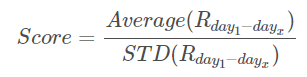

The following functions have put together that. Thank you for preparing.

In [ ]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

##1.2 [Case verification] Score calculation:¶

Let's calculate the score of this competition with a function only in 2021 where 2000 stocks are available.

##1.2.1 Filtering for explanation

In [ ]:
idcount = stock_prices.groupby("Date")["SecuritiesCode"].count().reset_index()
idcount

,Date,SecuritiesCode
0,2017-01-04,1865
1,2017-01-05,1865
2,2017-01-06,1865
3,2017-01-10,1865
4,2017-01-11,1865
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


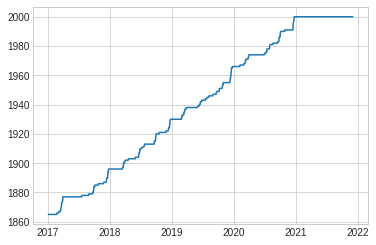

In [ ]:
plt.plot(idcount["Date"],idcount["SecuritiesCode"])

Depending on the date, there are cases where there are not 2000 stocks, so only those with 2000 are pulled.

In [ ]:
idcount.loc[idcount["SecuritiesCode"]==2000,:]

,Date,SecuritiesCode
970,2020-12-23,2000
971,2020-12-24,2000
972,2020-12-25,2000
973,2020-12-28,2000
974,2020-12-29,2000
...,...,...
1197,2021-11-29,2000
1198,2021-11-30,2000
1199,2021-12-01,2000
1200,2021-12-02,2000


It seems that 2000 pieces are available from December 23, 2020. For the easy understanding, let's calculate only for 2021.

In [ ]:

stock_prices2 = stock_prices.loc[stock_prices["Date"]>= "2021-01-01"].reset_index(drop=True)
stock_prices2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20210104_1301,2021-01-04,1301,2951.0,2951.0,2913.0,2950.0,9700,1.0,NaN,False,0.011502
1,20210104_1332,2021-01-04,1332,428.0,429.0,416.0,421.0,1780500,1.0,NaN,False,0.019093
2,20210104_1333,2021-01-04,1333,2229.0,2231.0,2179.0,2202.0,112400,1.0,NaN,False,0.015075
3,20210104_1375,2021-01-04,1375,1701.0,1701.0,1672.0,1674.0,67900,1.0,NaN,False,-0.003503
4,20210104_1376,2021-01-04,1376,1597.0,1597.0,1577.0,1588.0,4500,1.0,NaN,False,-0.012033
...,...,...,...,...,...,...,...,...,...,...,...,...
451995,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
451996,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
451997,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
451998,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


It seems that you have to prepare Rank yourself. I will put it out in one shot.

In [ ]:
stock_prices2["Rank"] = stock_prices2.groupby("Date")["Target"].rank(ascending=False,method="first") -1 
stock_prices2["Rank"] =stock_prices2["Rank"].astype("int") # float
stock_prices2

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20210104_1301,2021-01-04,1301,2951.0,2951.0,2913.0,2950.0,9700,1.0,NaN,False,0.011502,655
1,20210104_1332,2021-01-04,1332,428.0,429.0,416.0,421.0,1780500,1.0,NaN,False,0.019093,375
2,20210104_1333,2021-01-04,1333,2229.0,2231.0,2179.0,2202.0,112400,1.0,NaN,False,0.015075,497
3,20210104_1375,2021-01-04,1375,1701.0,1701.0,1672.0,1674.0,67900,1.0,NaN,False,-0.003503,1481
4,20210104_1376,2021-01-04,1376,1597.0,1597.0,1577.0,1588.0,4500,1.0,NaN,False,-0.012033,1737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451995,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816,580
451996,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478,1119
451997,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302,1941
451998,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098,1768


In [ ]:
stock_prices2['Rank'].min()

0

Calculated below. Portfolio_size is the weight of 200 pieces above and below. toprank_weight_ratio means to multiply evenly spaced weights between 1-2.

In [ ]:
score = calc_spread_return_sharpe(stock_prices2, portfolio_size= 200, toprank_weight_ratio= 2)
score

5.790745112881357

And, the score in this period came out. The person with this big wins.

# 2.What do you predict the Rank from? 

(Look at the data)
First of all, there are many folders, so what does that mean?


*   data_specifications : Folder with files that define what the columns in each file mean

*   train_files : A data folder that covers the main training period.

*   Supplemental_files : Probably, the latest stock price data will be updated in early May, early June, and one week before the end of the competition.
*   example_test_files : An example of the file format provided at the time of submit. Since Target is not included, you can calculate by yourself from Close.

# 2.무엇에서 순위를 예측합니까?

(데이터를 보라)
우선 폴더가 많은데 그게 무슨 뜻인가요?


* data_specifications : 각 파일의 열이 의미하는 바를 정의하는 파일이 있는 폴더

* train_files : 주요 train 기간을 다루는 데이터 폴더입니다.

* Supplemental_files :*** 아마도 5월 초, 6월 초, 대회 종료 일주일 전 최신 주가 데이터가 업데이트될 것입니다.***
* example_test_files : 제출 시 제공되는 파일 형식의 예. Target은 포함되어 있지 않으므로 Close에서 스스로 계산할 수 있습니다.









##2.1 For the time being, let's look only at the contents of the main train_files (the meaning of column shows data_specifications)

###2.1.1 stock_prices

The core file of interest. Includes the daily closing price for each stock and the target column.

In [ ]:
stock_prices = pd.read_csv("/content/gdrive/MyDrive/JPX/dataset/JPX/train_files/stock_prices.csv")
stock_prices.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154


In [ ]:
trades_spec = pd.read_csv("/content/gdrive/MyDrive/JPX/dataset/JPX/data_specifications/trades_spec.csv")
trades_spec

,index,Column,Sample value,Type,Addendum,Remarks
0,0,PublishedDate,2017-01-13,date,NaN,"data published data, usually Thursday on the f..."
1,0,StartDate,2017-01-04,date,NaN,The first trading date in this trading week
2,1,EndDate,2017-01-06,date,NaN,The last trading date in this trading week
3,2,Section,Prime Market (First Section),string,NaN,Market division name
4,3,TotalSales,8476800009,Int64,NaN,Please check below documents.\n\nPublished fil...
5,4,TotalPurchases,8483346362,Int64,NaN,NaN
6,5,TotalTotal,16960146371,Int64,NaN,NaN
7,6,TotalBalance,6546353,Int64,NaN,NaN
8,7,ProprietarySales,1311271004,Int64,NaN,NaN
9,8,ProprietaryPurchases,1453326508,Int64,NaN,NaN


###2.1.2 trades

In [ ]:
trades = pd.read_csv("/content/gdrive/MyDrive/JPX/dataset/JPX/train_files/trades.csv")
trades.head(3)

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,...,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Aggregated summary of trading volumes from the previous business week.

In [ ]:
trades_spec = pd.read_csv(path +'/data_specifications/trades_spec.csv')
trades_spec

,index,Column,Sample value,Type,Addendum,Remarks
0,0,PublishedDate,2017-01-13,date,NaN,"data published data, usually Thursday on the f..."
1,0,StartDate,2017-01-04,date,NaN,The first trading date in this trading week
2,1,EndDate,2017-01-06,date,NaN,The last trading date in this trading week
3,2,Section,Prime Market (First Section),string,NaN,Market division name
4,3,TotalSales,8476800009,Int64,NaN,Please check below documents.\n\nPublished fil...
5,4,TotalPurchases,8483346362,Int64,NaN,NaN
6,5,TotalTotal,16960146371,Int64,NaN,NaN
7,6,TotalBalance,6546353,Int64,NaN,NaN
8,7,ProprietarySales,1311271004,Int64,NaN,NaN
9,8,ProprietaryPurchases,1453326508,Int64,NaN,NaN


###2.1.3 secondary_stock_prices

In [ ]:
secondary_stock_prices = pd.read_csv(path +"/train_files/secondary_stock_prices.csv")
secondary_stock_prices.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1305,2017-01-04,1305,1594.0,1618.0,1594.0,1615.0,538190,1.0,NaN,False,-0.001855
1,20170104_1306,2017-01-04,1306,1575.0,1595.0,1573.0,1593.0,2494980,1.0,NaN,False,-0.000627
2,20170104_1308,2017-01-04,1308,1557.0,1580.0,1557.0,1578.0,526100,1.0,NaN,False,-0.001900


The core dataset contains on the 2,000 most commonly traded equities but many less liquid securities are also traded on the Tokyo market. This file contains data for those securities, which aren't scored but may be of interest for assessing the market as a whole.

핵심 데이터 세트에는 가장 일반적으로 거래되는 2,000개의 주식이 포함되어 있지만 도쿄 시장에서 거래되는 유동성이 적은 증권도 훨씬 많습니다. 이 파일에는 점수가 매겨지지는 않았지만 시장 전체를 평가하는 데 관심이 있을 수 있는 해당 증권에 대한 데이터가 포함되어 있습니다.

###2.1.4 options

In [ ]:
options = pd.read_csv(path + "/train_files/options.csv")
options.head(3)

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0


Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly.

더 넓은 시장을 기반으로 한 다양한 옵션의 상태에 대한 데이터. 많은 옵션에는 주식 시장의 미래 가격에 대한 암시적 예측이 포함되어 있으므로 옵션에 직접 점수를 매기지 않더라도 관심을 가질 수 있습니다.


In [ ]:
options_spec = pd.read_csv(path + "/data_specifications/options_spec.csv")
options_spec

,Column,Sample value,Type,Addendum,Remarks
0,DateCode,20170104_144122718,string,NaN,Unique ID for option price records
1,Date,2017-01-04 0:00:00,date,NaN,Trade date and time
2,OptionsCode,144122718,string,NaN,Local Securities Code (link to https://www.jpx...
3,WholeDayOpen,0,float,NaN,Opening Price for Whole Trading Day
4,WholeDayHigh,0,float,NaN,High Price for Whole Trading Day
5,WholeDayLow,0,float,NaN,Low Price for Whole Trading Day
6,WholeDayClose,0,float,NaN,Closing Price for Whole Trading Day
7,NightSessionOpen,0,float,NaN,Opening Price for Night Session
8,NightSessionHigh,0,float,NaN,High Price for Night Session
9,NightSessionLow,0,float,NaN,Low Price for Night Session


###2.1.5 financials

In [ ]:
financials = pd.read_csv(path+"/train_files/financials.csv")
financials.head(3)

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0
2,2.016123e+13,20170104_4575,2017-01-04,4575.0,2017-01-04,12:00:00,1.483499e+09,ForecastRevision,2016-12-31,2Q,...,-93.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Results from quarterly earnings reports.

##2.2 stocklist : This is separate from the folder

In [ ]:
stock_list = pd.read_csv(path+"/stock_list.csv")
stock_list.head(3)

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False


Relationship between Securities Code and company name

In [ ]:
stock_list_spec = pd.read_csv(path + "/data_specifications/stock_list_spec.csv")
stock_list_spec

,Column,Sample value,Type,Addendum,Remarks
0,SecuritiesCode,1301,Int64,NaN,Local Securities Code
1,EffectiveDate,20211230,date,NaN,the effective date
2,Name,"KYOKUYO CO.,LTD.",string,NaN,Name of security
3,Section/Products,First Section (Domestic),string,NaN,Section/Product
4,NewMarketSegment,Prime Market,string,NaN,New market segment effective from 2022-04-04 (...
5,33SectorCode,50,Int64,NaN,33 Sector Name\n\nref. https://www.jpx.co.jp/e...
6,33SectorName,"Fishery, Agriculture and Forestry",string,NaN,33 Sector Name\n\nref. https://www.jpx.co.jp/e...
7,17SectorCode,1,Int64,NaN,17 Sector Code\nref. https://www.jpx.co.jp/eng...
8,17SectorName,FOODS,string,NaN,17 Sector Name\nref. https://www.jpx.co.jp/eng...
9,NewIndexSeriesSizeCode,7,Int64,NaN,TOPIX New Index Series code\n\nref. https://ww...


#3.submit : time series api

time series api is

Data comes for a certain period (for example, the first day) → Predict it → Submit it

→ Data will come for a certain period (for example, the second day) → Predict it → Submit it

→ Data will come for a certain period (for example, the 3rd day) → Predict it → Submit it

・ ・ ・ It repeats. This time, the submission deadline is 2022 / 7/5. It is said that the winners will be announced on 10/7 with the real data after that.

In [ ]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

ModuleNotFoundError: ignored

The following for statement is. For the time being, let's take a look at one dose.

Rewrite Rank in sample_prediction,

Submit once with env.predict,

For the easy understanding, let's break once and see what's going on, but usually we don't break and just let it flow.

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    break

NameError: ignored

In [ ]:
counter = 0
# The API will deliver six dataframes in this specific order:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    if counter == 0:
        print(prices.head())
        print(options.head())
        print(financials.head())
        print(trades.head())
        print(secondary_prices.head())
        print(sample_prediction.head())
    sample_prediction['Rank'] = np.arange(len(sample_prediction))
    env.predict(sample_prediction)
    counter += 1

NameError: ignored

In [ ]:
! head submission.csv

head: cannot open 'submission.csv' for reading: No such file or directory


In [ ]:
prices.head(3)

NameError: ignored

In [ ]:
options.head(3)

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,...,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,...,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0


In [ ]:
financials.head(3)

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0
2,2.016123e+13,20170104_4575,2017-01-04,4575.0,2017-01-04,12:00:00,1.483499e+09,ForecastRevision,2016-12-31,2Q,...,-93.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
trades.head(3)

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,...,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
secondary_prices.head(3)

NameError: ignored

In [ ]:
sample_prediction.head(3)

NameError: ignored

Edit and submit sample_prediction.head () here

##3.1 Trial submit: Submit by substituting all the ranks of the last day as they are.

In [ ]:
stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2332527,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2332528,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302
2332529,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,False,0.009098


Stock_prices in train_files earlier is up to 2021-12-03.

In [ ]:
supplemental_stock_prices = pd.read_csv(path+"/supplemental_files/stock_prices.csv")
supplemental_stock_prices

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963
3,20211206_1375,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,NaN,False,-0.015032
4,20211206_1376,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,NaN,False,0.002867
...,...,...,...,...,...,...,...,...,...,...,...,...
195988,20220428_9990,2022-04-28,9990,497.0,504.0,494.0,504.0,51900,1.0,NaN,False,0.024048
195989,20220428_9991,2022-04-28,9991,776.0,786.0,774.0,784.0,23400,1.0,NaN,False,0.011378
195990,20220428_9993,2022-04-28,9993,1520.0,1530.0,1510.0,1517.0,8100,1.0,NaN,False,-0.005941
195991,20220428_9994,2022-04-28,9994,2471.0,2489.0,2457.0,2485.0,7800,1.0,NaN,False,0.005602


Stock_prices in supplemental_files, which will be updated from time to time, is until 2022-02-28. I will paste the rank of 2022-02-28 as it is and submit it.

In [ ]:
supplemental_stock_prices["Rank"] = supplemental_stock_prices.groupby("Date")["Target"].rank(ascending=False,method="first") -1
supplemental_stock_prices.head(3)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20211206_1301,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,NaN,False,-0.003263,1394.0
1,20211206_1332,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,NaN,False,-0.008993,1670.0
2,20211206_1333,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,NaN,False,-0.009963,1712.0


In [ ]:
finday = supplemental_stock_prices[supplemental_stock_prices["Date"]=="2022-02-28"].reset_index(drop=True)
finday

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20220228_1301,2022-02-28,1301,3180.0,3265.0,3170.0,3265.0,28700,1.0,NaN,False,-0.007692,514.0
1,20220228_1332,2022-02-28,1332,531.0,545.0,531.0,544.0,2437900,1.0,NaN,False,-0.024209,1293.0
2,20220228_1333,2022-02-28,1333,2474.0,2522.0,2468.0,2515.0,190100,1.0,NaN,False,-0.022106,1199.0
3,20220228_1375,2022-02-28,1375,1189.0,1205.0,1175.0,1201.0,59500,1.0,NaN,False,-0.009909,618.0
4,20220228_1376,2022-02-28,1376,1556.0,1580.0,1555.0,1570.0,12200,1.0,NaN,False,-0.007270,498.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20220228_9990,2022-02-28,9990,511.0,518.0,509.0,516.0,120600,1.0,NaN,False,-0.013592,789.0
1996,20220228_9991,2022-02-28,9991,823.0,825.0,814.0,822.0,16200,1.0,NaN,False,-0.020581,1123.0
1997,20220228_9993,2022-02-28,9993,1600.0,1622.0,1600.0,1600.0,4000,1.0,NaN,False,0.005762,136.0
1998,20220228_9994,2022-02-28,9994,2568.0,2568.0,2540.0,2565.0,9000,1.0,NaN,False,-0.002341,333.0


In [ ]:
finday[finday["Rank"]==finday["Rank"].iloc[0]]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Rank
0,20220228_1301,2022-02-28,1301,3180.0,3265.0,3170.0,3265.0,28700,1.0,NaN,False,-0.007692,514.0


In [ ]:
finday["Rank"] = finday["Rank"].astype("int")

Make it into a dictionary

In [ ]:
findaydict = dict(zip(finday["SecuritiesCode"],finday["Rank"]))

Edit sample_prediction for submit

In [ ]:
sample_prediction.head(3)

NameError: ignored

In [ ]:
sample_prediction["Rank"]  = sample_prediction["SecuritiesCode"].map(findaydict)
sample_prediction

NameError: ignored

Submit once

In [ ]:
env.predict(sample_prediction)

## Submit the rest with a for statement
(For the easy understanding, I broke once in ↑, but usually only the following image)

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    sample_prediction['Rank'] = sample_prediction["SecuritiesCode"].map(findaydict)
    env.predict(sample_prediction)

In [ ]:
sample_prediction